# Exploratory Data Analysis

In this notebook we will do most of the exploratory data analysis (we will do some later after we have created certain features)

## Objective

Predict total sales for every product and store in the next month.

Success is measured by low error in terms of root mean squared difference

$$\displaystyle \operatorname {RMSD} ={\sqrt {\frac {\sum _{t=1}^{T}({\hat {y}}_{t}-y_{t})^{2}}{T}}}$$

**NOTE**: The `RMSE` must be clipped to `[0,20]`

# TOC

* [1 Loading the dataset](#1-Loading-the-dataset)
* [2 Check if train and test contain the same data](#2-Check-if-train-and-test-contain-the-same-data)
* [3 Missing values](#3-Missing-values)
* [4 Target investigation](#4-Target-investigation)
* [5 Dates investigation](#5-Dates-investigation)
* [6 Price investigation](#6-Price-investigation)
* [7 Item and shop investigation](#7-Item-and-shop-investigation)
* [8 Correlation check](#8-Correlation-check)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# 1 Loading the dataset

## File descriptions

* `sales_train.csv` - the training set. Daily historical data from January 2013 to October 2015.
* `test.csv` - the test set. You need to forecast the sales for these shops and products for November 2015.
* `sample_submission.csv` - a sample submission file in the correct format.
* `items.csv - supplemental` information about the items/products.
* `item_categories.csv` - supplemental information about the items categories.
* `shops.csv` - supplemental information about the shops.

In [3]:
data_dir = Path('.').absolute().joinpath('data')

sales_train = pd.read_csv(data_dir.joinpath('sales_train.csv.gz'))
sales_test = pd.read_csv(data_dir.joinpath('test.csv.gz'))
items = pd.read_csv(data_dir.joinpath('items.csv'))
item_categories = pd.read_csv(data_dir.joinpath('item_categories.csv'))
shops = pd.read_csv(data_dir.joinpath('shops.csv'))

## Data fields

* `ID` - an Id that represents a (Shop, Item) tuple within the test set
* `shop_id` - unique identifier of a shop
* `item_id` - unique identifier of a product
* `item_category_id` - unique identifier of item category
* `item_cnt_day` - number of products sold. You are predicting a monthly amount of this measure
* `item_price` - current price of an item
* `date` - date in format dd/mm/yyyy
* `date_block_num` - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* `item_name` - name of item
* `shop_name` - name of shop
* `item_category_name` - name of item category

In [4]:
print(f'sales_train has {sales_train.shape[0]} rows')
sales_train.head()

sales_train has 2935849 rows


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
print(f'sales_test has {sales_test.shape[0]} rows')
sales_test.head()

sales_test has 214200 rows


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
print(f'items has {items.shape[0]} rows')
items.head()

items has 22170 rows


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
print(f'item_categories has {item_categories.shape[0]} rows')
item_categories.head()

item_categories has 84 rows


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
print(f'shops has {shops.shape[0]} rows')
shops.head()

shops has 60 rows


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


For better plotting (integer ticks), we cast item counts to int

In [9]:
sales_train.loc[:, 'item_cnt_day'] = sales_train.loc[:, 'item_cnt_day'].astype(np.int32)

# 2 Check if train and test contain the same data

In [10]:
def check_sets(train, test, col):
    """
    Checks the overlap between the column values
    
    Parameters
    ----------
    train : DataFrame
        The train data
    test : DataFrame
        The test data
    col : str
        The column to check the overlap of
    """
    
    train_col = set(train.loc[:, col].unique())
    test_col = set(test.loc[:, col].unique())

    total = len(train_col.union(test_col))
    not_in_test = len(train_col - test_col)
    not_in_train = len(test_col - train_col)

    not_in_test_frac = 100*not_in_test/total
    not_in_train_frac = 100*not_in_train/total

    print(f'{not_in_test} {col} elements are in train, but not in test ({not_in_test_frac:.1f} %)')
    print(f'{not_in_train} {col} elements are in test, but not in train ({not_in_train_frac:.1f} %)')

In [11]:
check_sets(sales_train, sales_test, 'shop_id')

18 shop_id elements are in train, but not in test (30.0 %)
0 shop_id elements are in test, but not in train (0.0 %)


In [12]:
check_sets(sales_train, sales_test, 'item_id')

17070 item_id elements are in train, but not in test (77.0 %)
363 item_id elements are in test, but not in train (1.6 %)


We combine the shop ids and the item ids to check how much overlap there is between the combined features

In [13]:
shop_item_train = sales_train.loc[:, ['shop_id','item_id']].apply(lambda cols : f'{cols[0]}_{cols[1]}', axis=1)
shop_item_test = sales_test.loc[:, ['shop_id','item_id']].apply(lambda cols : f'{cols[0]}_{cols[1]}', axis=1)

check_sets(shop_item_train.to_frame('shop_item'), shop_item_test.to_frame('shop_item'), 'shop_item')

312720 shop_item elements are in train, but not in test (59.3 %)
102796 shop_item elements are in test, but not in train (19.5 %)


## Investigate the split

In [14]:
unique_train_shop = sales_train.loc[:, 'shop_id'].unique()
print(unique_train_shop)

[59 25 24 23 19 22 18 21 28 27 29 26  4  6  2  3  7  0  1 16 15  8 10 14
 13 12 53 31 30 32 35 56 54 47 50 42 43 52 51 41 38 44 37 46 45  5 57 58
 55 17  9 49 39 40 48 34 33 20 11 36]


In [15]:
unique_test_shop = sales_test.loc[:, 'shop_id'].unique()
print(unique_test_shop)

[ 5  4  6  3  2  7 10 12 28 31 26 25 22 24 21 15 16 18 14 19 42 50 49 53
 52 47 48 57 58 59 55 56 36 37 35 38 34 46 41 44 39 45]


Hard to see any patterns here, although there could be some

In [16]:
only_in_train = [shop for shop in unique_train_shop if shop not in unique_test_shop]
print(only_in_train)

[23, 27, 29, 0, 1, 8, 13, 30, 32, 54, 43, 51, 17, 9, 40, 33, 20, 11]


Not anything obvious here either. (Remember that the train set contains all shops)

In [17]:
print(shop_item_train.unique()[:100])
print(shop_item_train.unique()[-100:])

['59_22154' '25_2552' '25_2554' '25_2555' '25_2564' '25_2565' '25_2572'
 '25_2573' '25_2574' '25_2593' '25_2604' '25_2607' '25_2609' '25_2548'
 '25_2611' '25_2546' '25_2515' '25_2705' '25_2715' '25_2716' '25_2719'
 '25_2720' '25_2473' '25_2480' '25_2731' '25_2746' '25_2748' '25_2522'
 '25_2614' '25_2798' '25_2833' '25_2835' '25_2836' '25_2844' '25_2845'
 '25_2847' '25_2848' '25_2854' '25_2857' '25_2920' '25_2795' '25_2808'
 '25_2628' '25_2629' '25_2631' '25_2640' '25_2822' '25_2704' '25_2703'
 '25_2088' '25_2090' '25_2092' '25_2100' '25_2102' '25_2103' '25_2106'
 '25_2108' '25_2111' '25_2117' '25_2121' '25_2122' '25_2123' '25_2149'
 '25_2151' '25_2160' '25_2164' '25_2389' '25_2179' '25_2186' '25_2340'
 '25_2189' '25_2281' '25_2321' '25_2333' '25_2252' '25_2253' '25_2254'
 '25_2255' '25_2256' '25_2257' '25_2258' '25_2199' '25_2439' '25_2441'
 '25_2461' '25_2678' '25_2462' '25_2680' '25_2682' '25_2437' '25_2202'
 '25_2209' '25_2220' '25_2221' '25_2412' '25_2222' '25_2415' '25_2416'
 '25_

In [18]:
print(shop_item_test.unique()[:100])
print(shop_item_test.unique()[-100:])

['5_5037' '5_5320' '5_5233' '5_5232' '5_5268' '5_5039' '5_5041' '5_5046'
 '5_5319' '5_5003' '5_4806' '5_4843' '5_4607' '5_4869' '5_4870' '5_4872'
 '5_4874' '5_4678' '5_4892' '5_4964' '5_4717' '5_5002' '5_5823' '5_5814'
 '5_5900' '5_5907' '5_5908' '5_5643' '5_5657' '5_5675' '5_5666' '5_5668'
 '5_5669' '5_5672' '5_5653' '5_5678' '5_5674' '5_5671' '5_5845' '5_5841'
 '5_5840' '5_5820' '5_5821' '5_5822' '5_5824' '5_5826' '5_5827' '5_5828'
 '5_5829' '5_5837' '5_5838' '5_5839' '5_5459' '5_5830' '5_3731' '5_4719'
 '5_3341' '5_3343' '5_3350' '5_3351' '5_3352' '5_3364' '5_3365' '5_3537'
 '5_3538' '5_3571' '5_3676' '5_3677' '5_3678' '5_3686' '5_3604' '5_3353'
 '5_3334' '5_3331' '5_3407' '5_3408' '5_5962' '5_3405' '5_3423' '5_3442'
 '5_3443' '5_3444' '5_3445' '5_3464' '5_4244' '5_4248' '5_4249' '5_4107'
 '5_4351' '5_4357' '5_4365' '5_4367' '5_4385' '5_4389' '5_4479' '5_4442'
 '5_4363' '5_4240' '5_4233' '5_3732']
['45_18707' '45_17482' '45_14972' '45_15472' '45_16034' '45_13543'
 '45_13403' '45_117

Not really obvious that whether or not there is a pattern here.

Maybe we find something if we plot them in a 3-D plot.

<IPython.core.display.Javascript object>


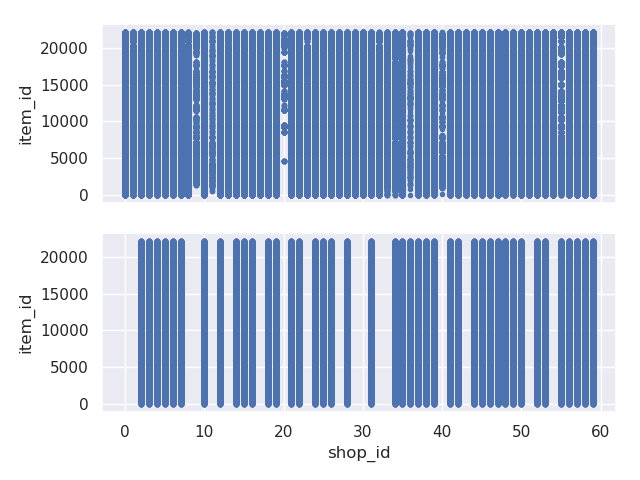

In [19]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
sales_train.plot('shop_id', 'item_id', style='.', ax=ax1)
sales_test.plot('shop_id', 'item_id', style='.', ax=ax2)
ax1.set_ylabel('item_id')
ax2.set_ylabel('item_id')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
plt.tight_layout()

It appers that a stripe in the train set has been removed. Let's check that up close

<IPython.core.display.Javascript object>


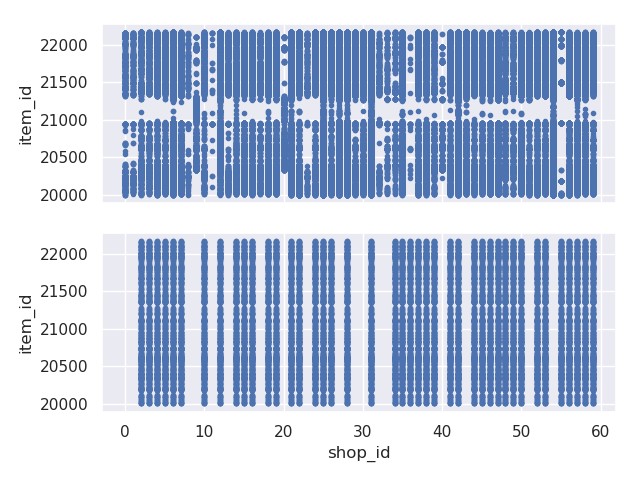

In [20]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
sales_train.loc[sales_train.loc[:, 'item_id'] > 20000].plot('shop_id', 'item_id', style='.', ax=ax1)
sales_test.loc[sales_test.loc[:, 'item_id'] > 20000].plot('shop_id', 'item_id', style='.', ax=ax2)
ax1.set_ylabel('item_id')
ax2.set_ylabel('item_id')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
plt.tight_layout()

That's peculiar. This can imply that the test data is not generated completely randomly (or maybe that the train data has been partially). We can actually see several of these stripes, alebeit with smaller bands

<IPython.core.display.Javascript object>


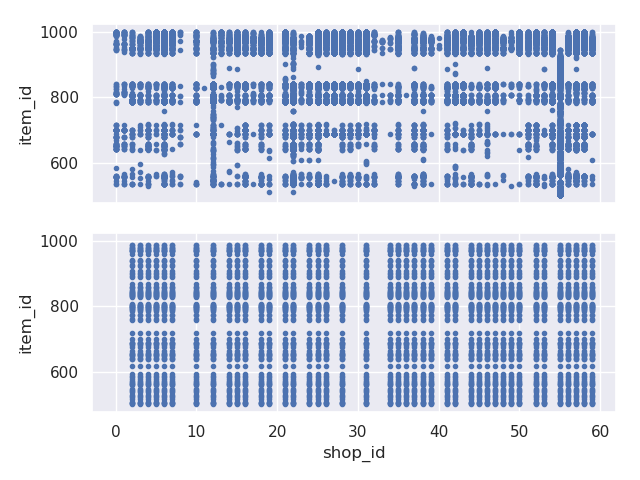

In [21]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
sales_train.loc[(sales_train.loc[:, 'item_id'] < 1000) & (sales_train.loc[:, 'item_id'] > 500)].plot('shop_id', 'item_id', style='.', ax=ax1)
sales_test.loc[(sales_test.loc[:, 'item_id'] < 1000) & (sales_test.loc[:, 'item_id'] > 500)].plot('shop_id', 'item_id', style='.', ax=ax2)
ax1.set_ylabel('item_id')
ax2.set_ylabel('item_id')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
plt.tight_layout()

It can appear like the shop id numbers where choosen at random, and possibly also the band and location of the item id numbers in the test set

# 3 Missing values

In [22]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

# 4 Target investigation

<IPython.core.display.Javascript object>


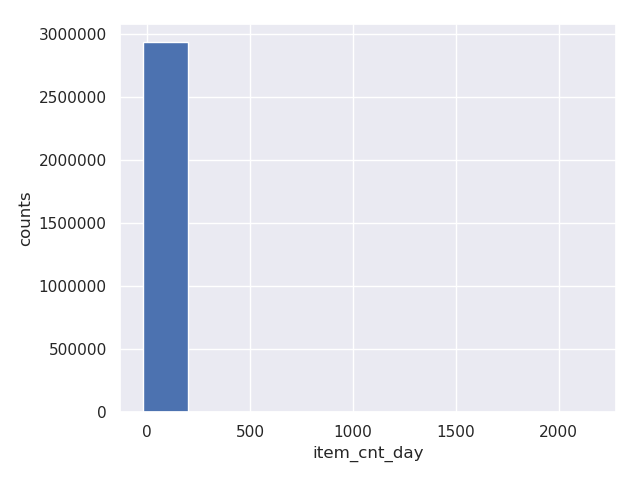

In [23]:
fig, ax = plt.subplots()
sales_train.loc[:, 'item_cnt_day'].hist(ax=ax)
ax.set_xlabel('item_cnt_day')
ax.set_ylabel('counts')
ax.grid(True)
plt.tight_layout()

Looks like we have a couple of outliners here

In [24]:
max_item_cnt = sales_train.loc[:, 'item_cnt_day'].max()
min_item_cnt = sales_train.loc[:, 'item_cnt_day'].min()

print(f'Max item count {max_item_cnt}')
print(f'Min item count {min_item_cnt}')

Max item count 2169
Min item count -22


### Right outliner

In [25]:
sales_train.loc[sales_train.loc[:, 'item_cnt_day'] == max_item_cnt]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169


In [26]:
ro_item_id = sales_train.loc[sales_train.loc[:, 'item_cnt_day'] == max_item_cnt, 'item_id'].values[0]
items.loc[items.loc[:, 'item_id'] == ro_item_id]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


This translates to something like "Delivery to the point of issue (Boxberry)", where it from Google looks like Boxberry is doing shipping to Russia

In [27]:
ro_item_id_cat = items.loc[items.loc[:, 'item_id'] == ro_item_id, 'item_category_id'].values[0]
item_categories.loc[item_categories.loc[:, 'item_category_id'] == ro_item_id_cat]

,item_category_name,item_category_id
9,Доставка товара,9


Which translates to delivery of goods...this may actually be a correct number

### Left outliner

In [28]:
sales_train.loc[sales_train.loc[:, 'item_cnt_day'] == min_item_cnt]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1057907,02.11.2013,10,12,8023,15.0,-22


This translates to something like "Delivery to the point of issue (Boxberry)", where it from Google looks like Boxberry is doing shipping to Russia

In [29]:
lo_item_id = sales_train.loc[sales_train.loc[:, 'item_cnt_day'] == min_item_cnt, 'item_id'].values[0]
items.loc[items.loc[:, 'item_id'] == lo_item_id]

,item_name,item_id,item_category_id
8023,ZL004 Лазерные наклейки Смайлики маленькие,8023,66


This translates to stickers, and (although peculiar, it could be that somebody delivered $22$ stickers)

### Clipped distribution

Let's plot the far right side of the distribution...

<IPython.core.display.Javascript object>


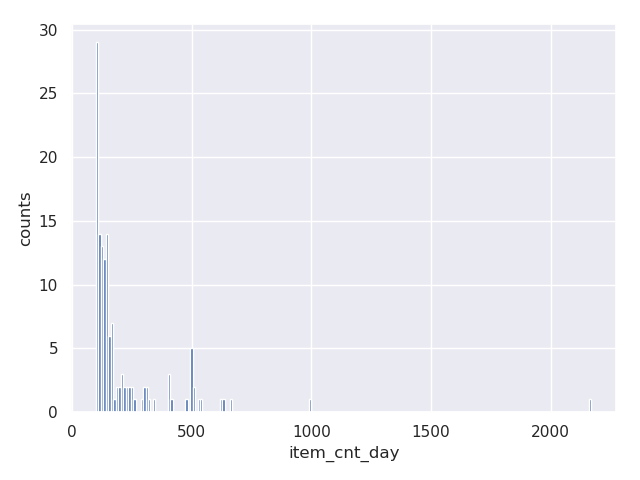

In [30]:
fig, ax = plt.subplots()
sales_train.loc[sales_train.loc[:, 'item_cnt_day'] > 100, 'item_cnt_day'].hist(ax=ax, bins=200)
ax.set_xlabel('item_cnt_day')
ax.set_ylabel('counts')
ax.grid(True)
plt.tight_layout()

...and the far left side of the distribution.

<IPython.core.display.Javascript object>


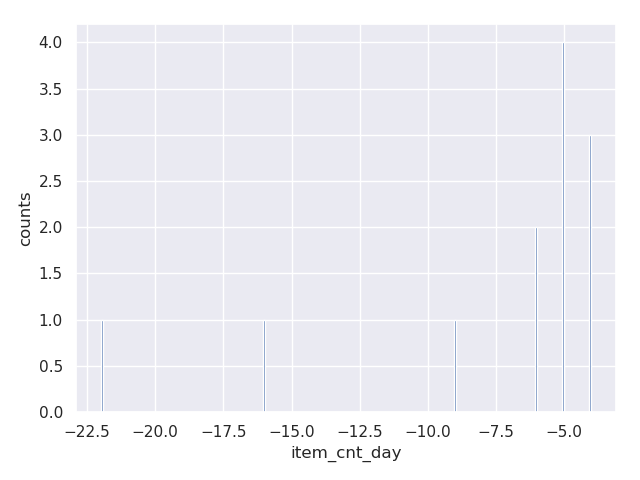

In [31]:
fig, ax = plt.subplots()
sales_train.loc[sales_train.loc[:, 'item_cnt_day'] < -3, 'item_cnt_day'].hist(ax=ax, bins=200)
ax.set_xlabel('item_cnt_day')
ax.set_ylabel('counts')
ax.grid(True)
plt.tight_layout()

As these outliers are few, it should be fairly safe to replace them with the mean.

Let us also investigate the logarithmic histogram of the bulk part of the distribution.

<IPython.core.display.Javascript object>


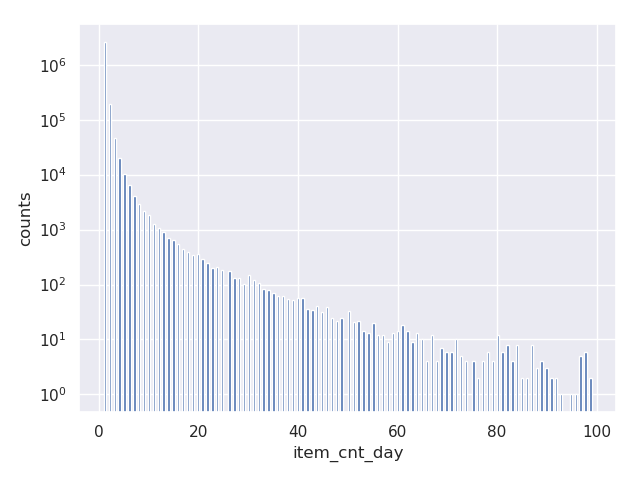

In [32]:
fig, ax = plt.subplots()
sales_train.loc[(sales_train.loc[:, 'item_cnt_day'] >= 0) & 
                (sales_train.loc[:, 'item_cnt_day'] < 100),
                 'item_cnt_day'].hist(ax =ax, bins=200, log=True)
ax.set_xlabel('item_cnt_day')
ax.set_ylabel('counts')
ax.grid(True)
plt.tight_layout()

Check the value count

In [33]:
sales_train.loc[:, 'item_cnt_day'].value_counts()

 1       2629372
 2        194201
 3         47350
 4         19685
 5         10474
-1          7252
 6          6338
 7          4057
 8          2903
 9          2177
 10         1820
 11         1263
 12         1083
 13          918
 14          716
 15          638
 16          544
 17          438
 18          391
 20          364
 19          347
 21          290
 22          242
 24          204
 23          198
 25          180
 26          176
 30          147
 28          131
 27          130
          ...   
 131           1
 132           1
 2169          1
 135           1
 93            1
 95            1
 140           1
 96            1
-16            1
 146           1
 147           1
 118           1
 149           1
 154           1
 217           1
 156           1
 157           1
 161           1
 163           1
 164           1
 167           1
 102           1
 105           1
 179           1
 187           1
 194           1
 195           1
 200          

**NOTE**: Zero values are not present

**NOTE**: We are clipping the final scores to $[0, 20]$, and we can test if this is better to do before or after the prediction (for the monthly aggregated values). Nevertheless, we should treat the outliners before doing so.

# 5 Date investigation

In [34]:
# Converting dd.mm.yyyy to yyyy.mm.dd
sortable_date = sales_train.loc[:, 'date'].str[6:] + '.' +\
                sales_train.loc[:, 'date'].str[3:5] + '.' +\
                sales_train.loc[:, 'date'].str[:2] 

In [35]:
max_date = sortable_date.max()
min_date = sortable_date.min()
print(f'First date in dataset: {min_date}')
print(f'Last date in dataset: {max_date}')

First date in dataset: 2013.01.01
Last date in dataset: 2015.10.31


In [36]:
sales_train.loc[sales_train.loc[:, 'date'] == f'{max_date[8:]}.{max_date[5:7]}.{max_date[:4]}'].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882340,31.10.2015,33,45,14227,99.0,1
2882451,31.10.2015,33,45,11593,299.0,1
2882455,31.10.2015,33,45,10438,299.0,1
2882469,31.10.2015,33,45,11141,199.0,1
2882507,31.10.2015,33,45,12362,249.0,1


Cast dates in string to timedate objects

**NOTE**: It is here important to specify the format, else we get nonsensical dates

In [37]:
sales_train_date = pd.to_datetime(sales_train.loc[:, 'date'], format='%d.%m.%Y')

Check that this is not affecting the range

In [38]:
max_date = sales_train_date.max()
min_date = sales_train_date.min()
print(f'First date in dataset: {min_date}')
print(f'Last date in dataset: {max_date}')

First date in dataset: 2013-01-01 00:00:00
Last date in dataset: 2015-10-31 00:00:00


In [39]:
sales_train.loc[sales_train_date == max_date].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882340,31.10.2015,33,45,14227,99.0,1
2882451,31.10.2015,33,45,11593,299.0,1
2882455,31.10.2015,33,45,10438,299.0,1
2882469,31.10.2015,33,45,11141,199.0,1
2882507,31.10.2015,33,45,12362,249.0,1


We can now safely replace the dates with datetime

In [40]:
sales_train.loc[:, 'date'] = sales_train_date

In [41]:
dates = pd.to_datetime(sales_train.loc[:, 'date'].unique())
date_range = pd.date_range(start=dates.min(), end=dates.max()).unique()
n_dates = len(dates)
n_date_range = len(date_range)
missing_pct = (1 - (n_dates/n_date_range))*100
print(f'{n_date_range - n_dates} days missing ({missing_pct:.1f} %)')

0 days missing (0.0 %)


## Check if there are some seasonal trends

<IPython.core.display.Javascript object>


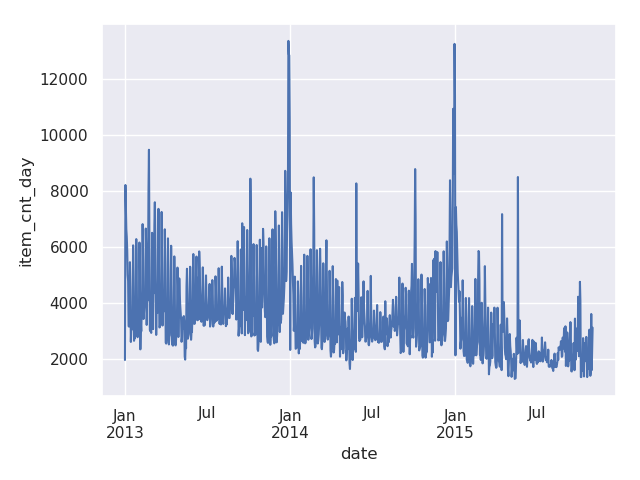

In [42]:
fig, ax = plt.subplots()
sales_train.groupby('date')['item_cnt_day'].sum().plot()
ax.set_ylabel('item_cnt_day')
ax.grid(True)
plt.tight_layout()

High sales in January, looks like the sales are not so high in 2015 compared to the previous years

<IPython.core.display.Javascript object>


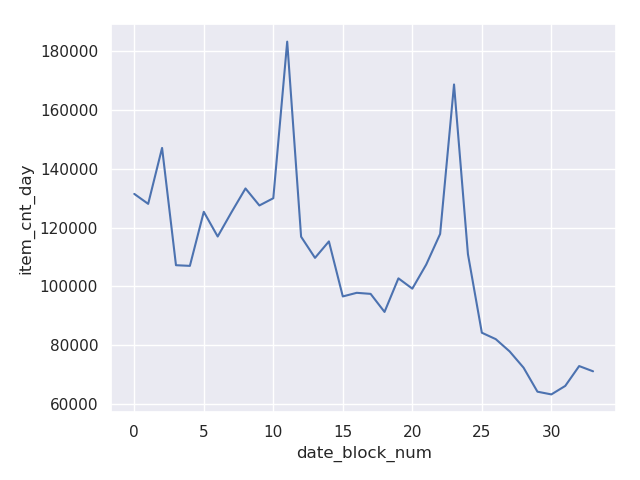

In [43]:
fig, ax = plt.subplots()
sales_train.groupby('date_block_num')['item_cnt_day'].sum().plot(ax=ax)
ax.set_ylabel('item_cnt_day')
ax.grid(True)
plt.tight_layout()

As expected, the same trends are observed in the `date_block_num`

# 6 Price investigation

<IPython.core.display.Javascript object>


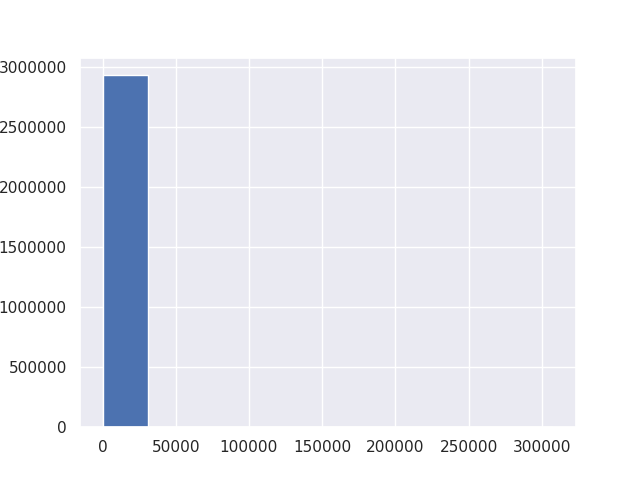

In [44]:
fig, ax = plt.subplots()
sales_train.loc[:, 'item_price'].hist(ax=ax)

In [45]:
max_price = sales_train.loc[:, 'item_price'].max()
min_price = sales_train.loc[:, 'item_price'].min()

print(f'Max price {max_price}')
print(f'Min price {min_price}')

Max price 307980.0
Min price -1.0


Looks like missing values has been encoded as $-1.0$

<IPython.core.display.Javascript object>


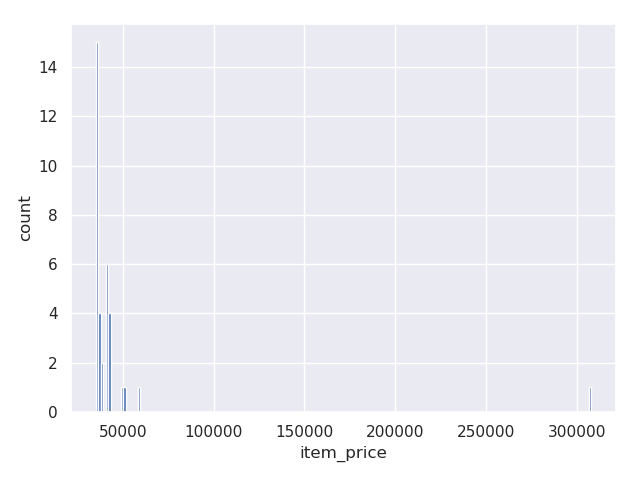

In [46]:
fig, ax = plt.subplots()
sales_train.loc[sales_train.loc[:, 'item_price'] > 35000, 'item_price'].hist(ax=ax, bins=200)
ax.set_xlabel('item_price')
ax.set_ylabel('count')
plt.tight_layout()

$5000$ RUB was a lot of money in the time under investigation. The last point appears to be an outliner.

In [47]:
high_prices = sales_train.loc[sales_train.loc[:, 'item_price'] > 40000].sort_values('item_price', ascending=False)
high_prices

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1
885138,2013-09-17,8,12,11365,59200.0,1
1488135,2014-03-20,14,25,13199,50999.0,1
2327159,2015-01-29,24,12,7241,49782.0,1
2885692,2015-10-23,33,42,13403,42990.0,1
2910156,2015-10-29,33,12,13403,42990.0,1
2917760,2015-10-20,33,3,13403,42990.0,1
2931380,2015-10-20,33,22,13403,42990.0,1
1006638,2013-10-24,9,12,7238,42000.0,1
2893100,2015-10-20,33,38,13403,41990.0,1


In [48]:
item_max_price = high_prices.iloc[0]['item_id']
items.loc[items.loc[:, 'item_id'] == item_max_price]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


This translates to "Radmin 3 - 522 individuals". In other words, the price may be actual.

In [49]:
sales_train.loc[sales_train.loc[:, 'item_id'] == item_max_price]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1


This was only sold once. It could be that this was a special order. One could consider to remove the point, or redo the `item_id` and change the `item_cnt_day`. 

In [50]:
[item for item in items.loc[:, 'item_name'] if 'admin' in item]

['Radmin 3  - 1 лиц.', 'Radmin 3  - 522 лиц.']

In [51]:
items.loc[items.loc[:, 'item_name'] == 'Radmin 3  - 1 лиц.']

,item_name,item_id,item_category_id
6065,Radmin 3 - 1 лиц.,6065,75


We check whether this is a commonly sold product, or if it's better to just remove the data point

In [52]:
sales_train.loc[sales_train.loc[:, 'item_id'] == 6065]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
291238,2013-03-21,2,22,6065,1299.0,1
291260,2013-03-22,2,22,6065,1299.0,1
318708,2013-03-11,2,25,6065,1299.0,1
370177,2013-04-18,3,12,6065,1299.0,1
375067,2013-04-06,3,6,6065,1299.0,1
379230,2013-04-12,3,22,6065,1299.0,1
379232,2013-04-20,3,22,6065,1299.0,2
487026,2013-05-05,4,54,6065,1299.0,1
542238,2013-06-07,5,29,6065,1299.0,1
679923,2013-07-29,6,22,6065,1299.0,1


We check if these are present in the test set

In [53]:
sales_test.loc[sales_test.loc[:, 'item_id'] == item_max_price]

,ID,shop_id,item_id


In [54]:
sales_test.loc[sales_test.loc[:, 'item_id'] == 6065]

,ID,shop_id,item_id
3484,3484,5,6065
8584,8584,4,6065
13684,13684,6,6065
18784,18784,3,6065
23884,23884,2,6065
28984,28984,7,6065
34084,34084,10,6065
39184,39184,12,6065
44284,44284,28,6065
49384,49384,31,6065


We see that these are present in the test set, and should be taken care of

In [55]:
second_item_max_price = high_prices.iloc[1]['item_id']
items.loc[items.loc[:, 'item_id'] == second_item_max_price]

,item_name,item_id,item_category_id
11365,Доставка (EMS),11365,9


It's possible that this translates to something like express mail service. It may that this was the actual price.

# 7 Item and shop investigation

<IPython.core.display.Javascript object>


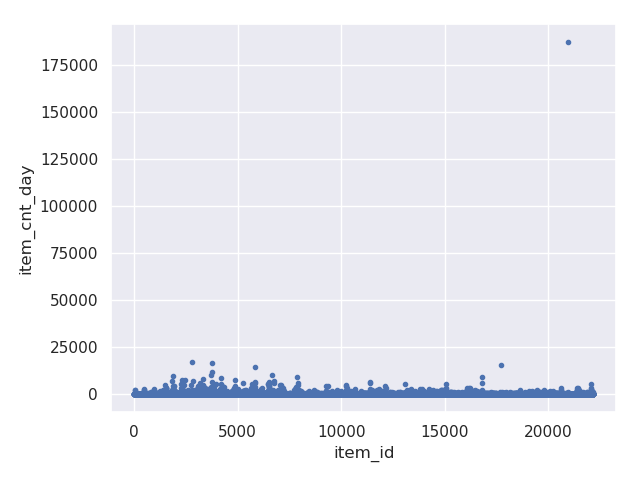

In [56]:
fig, ax = plt.subplots()
sales_train.groupby('item_id')['item_cnt_day'].sum().plot(ax=ax, style='.')
ax.set_xlabel('item_id')
ax.set_ylabel('item_cnt_day')
ax.grid(True)
plt.tight_layout()

We probably have one dominating prodcut, let's investigate further

In [57]:
max_item_id = sales_train.groupby('item_id')['item_cnt_day'].sum().idxmax()
items.loc[items.loc[:, 'item_id'] == max_item_id, 'item_name']

20949    Фирменный пакет майка 1С Интерес белый (34*42)...
Name: item_name, dtype: object

Deciding from Google images, it looks like this translates to plastic bags, so it could be that this number is in fact huge

<IPython.core.display.Javascript object>


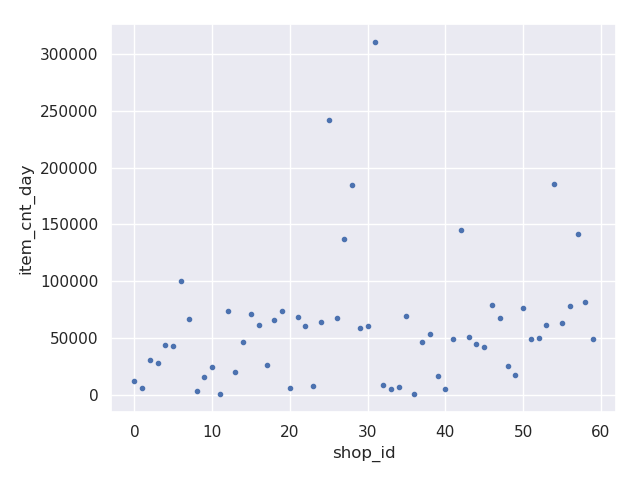

In [58]:
fig, ax = plt.subplots()
sales_train.groupby('shop_id')['item_cnt_day'].sum().plot(ax=ax, style='.')
ax.set_xlabel('shop_id')
ax.set_ylabel('item_cnt_day')
ax.grid(True)
plt.tight_layout()

The data seem to be sane, but we note that a few shops sells a lot more then the rest

<IPython.core.display.Javascript object>


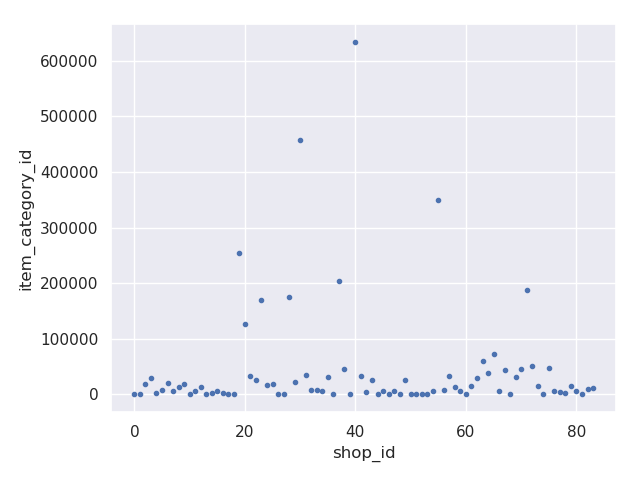

In [59]:
fig, ax = plt.subplots()
merged_train = pd.merge(sales_train, items, how='left', on=['item_id'])
merged_train.groupby('item_category_id')['item_cnt_day'].sum().plot(ax=ax, style='.')
ax.set_xlabel('shop_id')
ax.set_ylabel('item_category_id')
ax.grid(True)
plt.tight_layout()

As with the shop ids, it appears that a few categories are really contributing to the most of the number of items sold.

# 8 Correlation check

<IPython.core.display.Javascript object>


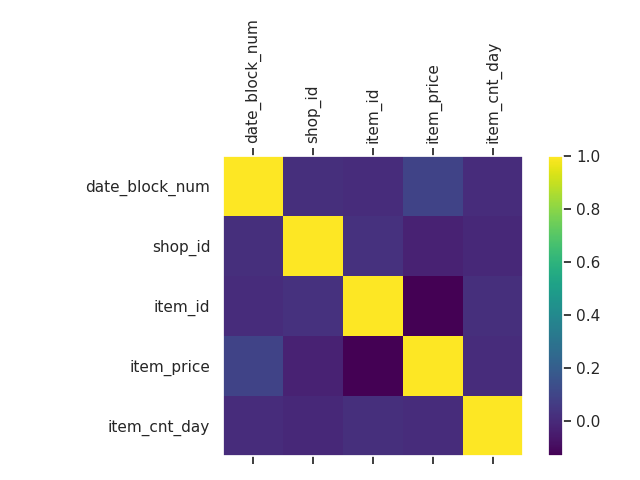

In [60]:
fig, ax = plt.subplots()
corr = sales_train.corr()
cax = ax.matshow(corr, cmap='viridis')
fig.colorbar(cax)
_ = ax.set_xticklabels([0]+list(corr.columns.values), rotation='vertical')
_ = ax.set_yticklabels([0]+list(corr.columns.values))
ax.grid(False)
plt.tight_layout()

In [61]:
corr

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


Not suprisingly: The item id is correlated with the price

<IPython.core.display.Javascript object>


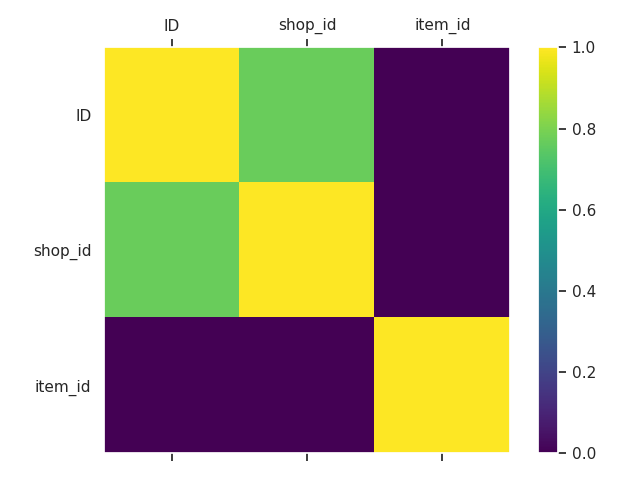

In [62]:
fig, ax = plt.subplots()
corr = sales_test.corr()
cax = ax.matshow(corr, cmap='viridis')
fig.colorbar(cax)
_ = ax.set_xticklabels([0]+list(corr.columns.values))
_ = ax.set_yticklabels([0]+list(corr.columns.values))
ax.grid(False)
plt.tight_layout()

In [63]:
corr

,ID,shop_id,item_id
ID,1.000000,7.706097e-01,2.283979e-03
shop_id,0.770610,1.000000e+00,-5.281183e-17
item_id,0.002284,-5.281183e-17,1.000000e+00


Intrestingly enough, we see that the `shop_id` is tightly correlated with the ID number. This is a leakage we can exploit.